
# Comparación de acelerogramas — AnyShake Explorer vs Raspberry Shake 4D (ENZ, ENN, ENE)
**Objetivo:** importar dos archivos miniSEED (mismo intervalo UTC) y comparar los acelerogramas de ambos instrumentos.  
Se realizan los siguientes pasos:
1. Detrend (quitar tendencia simple).  
2. Conversión a **Gals** usando las sensibilidades provistas:  
   - RS4D: `a (m/s²) = raw / 384500` → `a (Gal) = a(m/s²) * 100`  
   - AnyShake: `a (Gal) = raw * 0.1196413`  
3. Alineado temporal y remuestreo a la misma tasa de muestreo.  
4. Detección de los 6 impulsos más energéticos y extracción de ventanas alrededor de cada impulso.  
5. Cálculo de máximos y mínimos por impulso y por canal, comparación e gráficos.  

In [2]:
import numpy as np
from datetime import datetime, timedelta
from obspy import read, UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset

# === Parámetros editables ===
path_anyshake_ENZ = "AS.SHAKE.00.ENZ.D.2025.261.mseed"
path_anyshake_ENE = "AS.SHAKE.00.ENE.D.2025.261.mseed"
path_anyshake_ENN = "AS.SHAKE.00.ENN.D.2025.261.mseed"
path_rs4d         = "RF7EE-18-sep-2025.mseed"

starttime = UTCDateTime("2025-09-18T21:29:58") + 50
endtime   = UTCDateTime("2025-09-18T21:36:50")

st_rs4d = read(path_rs4d)
st_rs4d = st_rs4d.slice(starttime, endtime)
st_rs = st_rs4d.select(channel="EN?")
st_anyshake = read(path_anyshake_ENZ) + read(path_anyshake_ENE) + read(path_anyshake_ENN)
st_anyshake = st_anyshake.slice(starttime, endtime)

print(st_anyshake)
print(st_rs)

st_anyshake.detrend(type="linear")
st_rs.detrend(type="linear")

3 Trace(s) in Stream:
AS.SHAKE.00.ENZ | 2025-09-18T21:30:48.003000Z - 2025-09-18T21:36:50.003000Z | 100.0 Hz, 36201 samples
AS.SHAKE.00.ENE | 2025-09-18T21:30:48.003000Z - 2025-09-18T21:36:50.003000Z | 100.0 Hz, 36201 samples
AS.SHAKE.00.ENN | 2025-09-18T21:30:48.003000Z - 2025-09-18T21:36:50.003000Z | 100.0 Hz, 36201 samples
3 Trace(s) in Stream:
AM.RF7EE.00.ENE | 2025-09-18T21:30:47.998000Z - 2025-09-18T21:36:49.998000Z | 100.0 Hz, 36201 samples
AM.RF7EE.00.ENN | 2025-09-18T21:30:47.998000Z - 2025-09-18T21:36:49.998000Z | 100.0 Hz, 36201 samples
AM.RF7EE.00.ENZ | 2025-09-18T21:30:47.998000Z - 2025-09-18T21:36:49.998000Z | 100.0 Hz, 36201 samples


3 Trace(s) in Stream:
AM.RF7EE.00.ENE | 2025-09-18T21:30:47.998000Z - 2025-09-18T21:36:49.998000Z | 100.0 Hz, 36201 samples
AM.RF7EE.00.ENN | 2025-09-18T21:30:47.998000Z - 2025-09-18T21:36:49.998000Z | 100.0 Hz, 36201 samples
AM.RF7EE.00.ENZ | 2025-09-18T21:30:47.998000Z - 2025-09-18T21:36:49.998000Z | 100.0 Hz, 36201 samples

In [3]:
def anyshake_to_gal(stream):
    """
    Convierte las cuentas crudas de AnyShake a Gals.
    1 Gal = 0.119 * valor crudo
    """
    st_conv = stream.copy()
    for tr in st_conv:
        tr.data = tr.data * 0.119
    return st_conv

def rs4d_to_gal(stream):
    """
    Convierte las cuentas crudas de RS4D a m/s² (aproximadamente Gals: 1 Gal = 0.01 m/s²)
    1 m/s² = valor crudo / 384500
    """
    st_conv = stream.copy()
    for tr in st_conv:
        tr.data = (tr.data / 384500.0)*100
    return st_conv

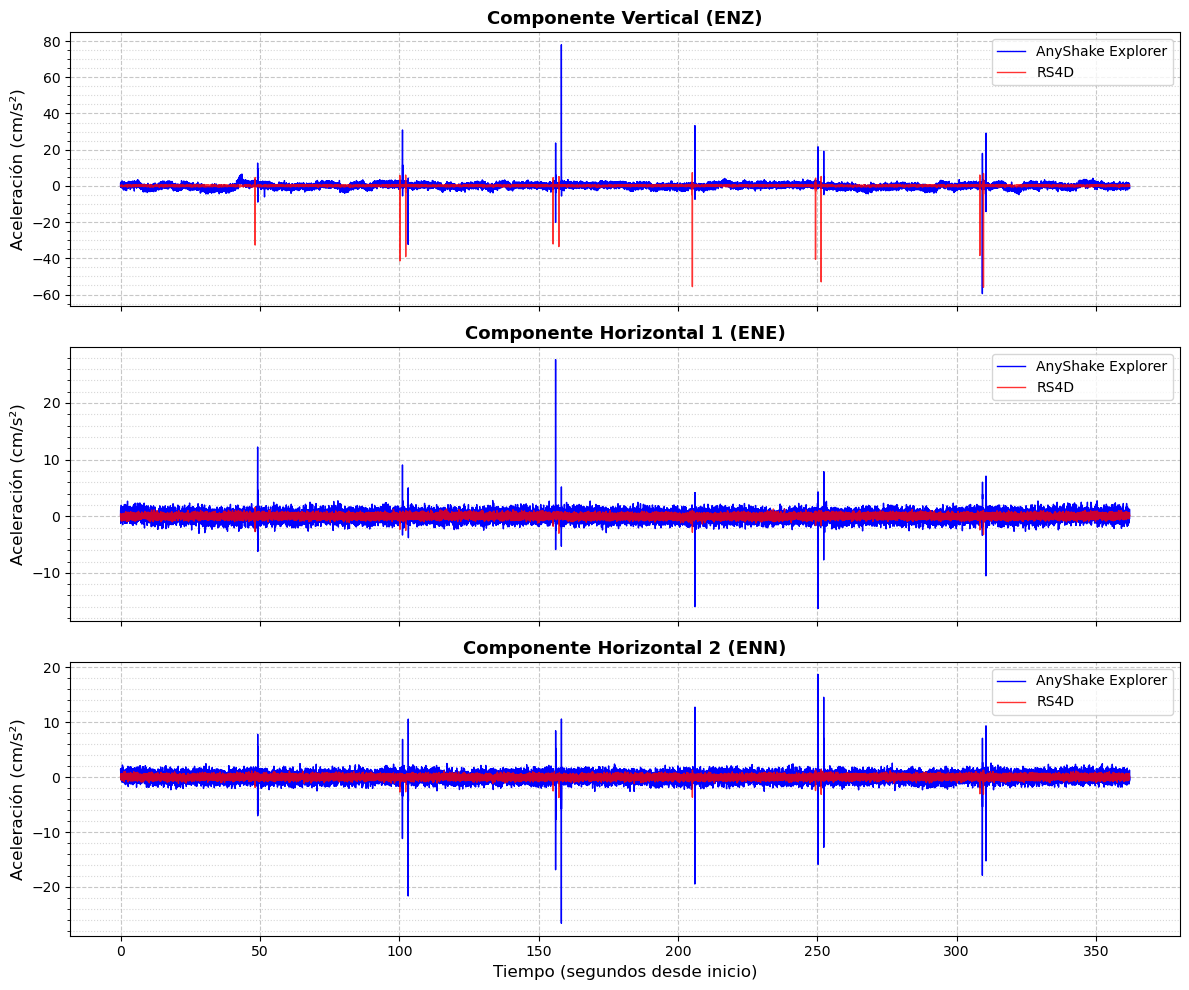

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# Convertir ambas señales a unidades de aceleración (cm/s²)
st_anyshake_gal = anyshake_to_gal(st_anyshake)
st_rs4d_gal = rs4d_to_gal(st_rs)

# Crear figura con 3 subgráficas
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Definir colores para cada instrumento
colors = {'AnyShake': 'blue', 'RS4D': 'red'}

# Graficar cada componente
components = ['ENZ', 'ENE', 'ENN']
titles = ['Componente Vertical (ENZ)', 'Componente Horizontal 1 (ENE)', 'Componente Horizontal 2 (ENN)']

for i, (comp, title) in enumerate(zip(components, titles)):
    ax = axes[i]
    
    # Obtener datos de AnyShake
    tr_anyshake = st_anyshake_gal.select(channel=f"*{comp}")[0]
    time_anyshake = np.linspace(0, len(tr_anyshake.data) * tr_anyshake.stats.delta, len(tr_anyshake.data))
    
    # Obtener datos de RS4D
    tr_rs4d = st_rs4d_gal.select(channel=f"*{comp}")[0]
    time_rs4d = np.linspace(0, len(tr_rs4d.data) * tr_rs4d.stats.delta, len(tr_rs4d.data))
    
    # Graficar ambas señales
    ax.plot(time_anyshake, tr_anyshake.data, 
            color=colors['AnyShake'], linewidth=1, label='AnyShake Explorer')
    ax.plot(time_rs4d, tr_rs4d.data, 
            color=colors['RS4D'], linewidth=1, label='RS4D', alpha=0.8)
    
    # Configurar cada subgráfica
    ax.set_ylabel('Aceleración (cm/s²)', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper right')
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Añadir cuadrícula secundaria
    ax.grid(True, which='minor', linestyle=':', alpha=0.5)

# Configurar eje X común
axes[-1].set_xlabel('Tiempo (segundos desde inicio)', fontsize=12)
axes[-1].tick_params(axis='x', which='major', labelsize=10)

# Ajustar espaciado
plt.tight_layout()
plt.subplots_adjust(hspace=0.15)

# Mostrar figura
plt.savefig('All_impulses.png', dpi=300, bbox_inches='tight')
plt.show()

# Opcional: Guardar figura
# plt.savefig('comparacion_aceleraciones.png', dpi=300, bbox_inches='tight')

Duración de los datos:
AnyShake: 362.0 segundos
RS4D: 362.0 segundos


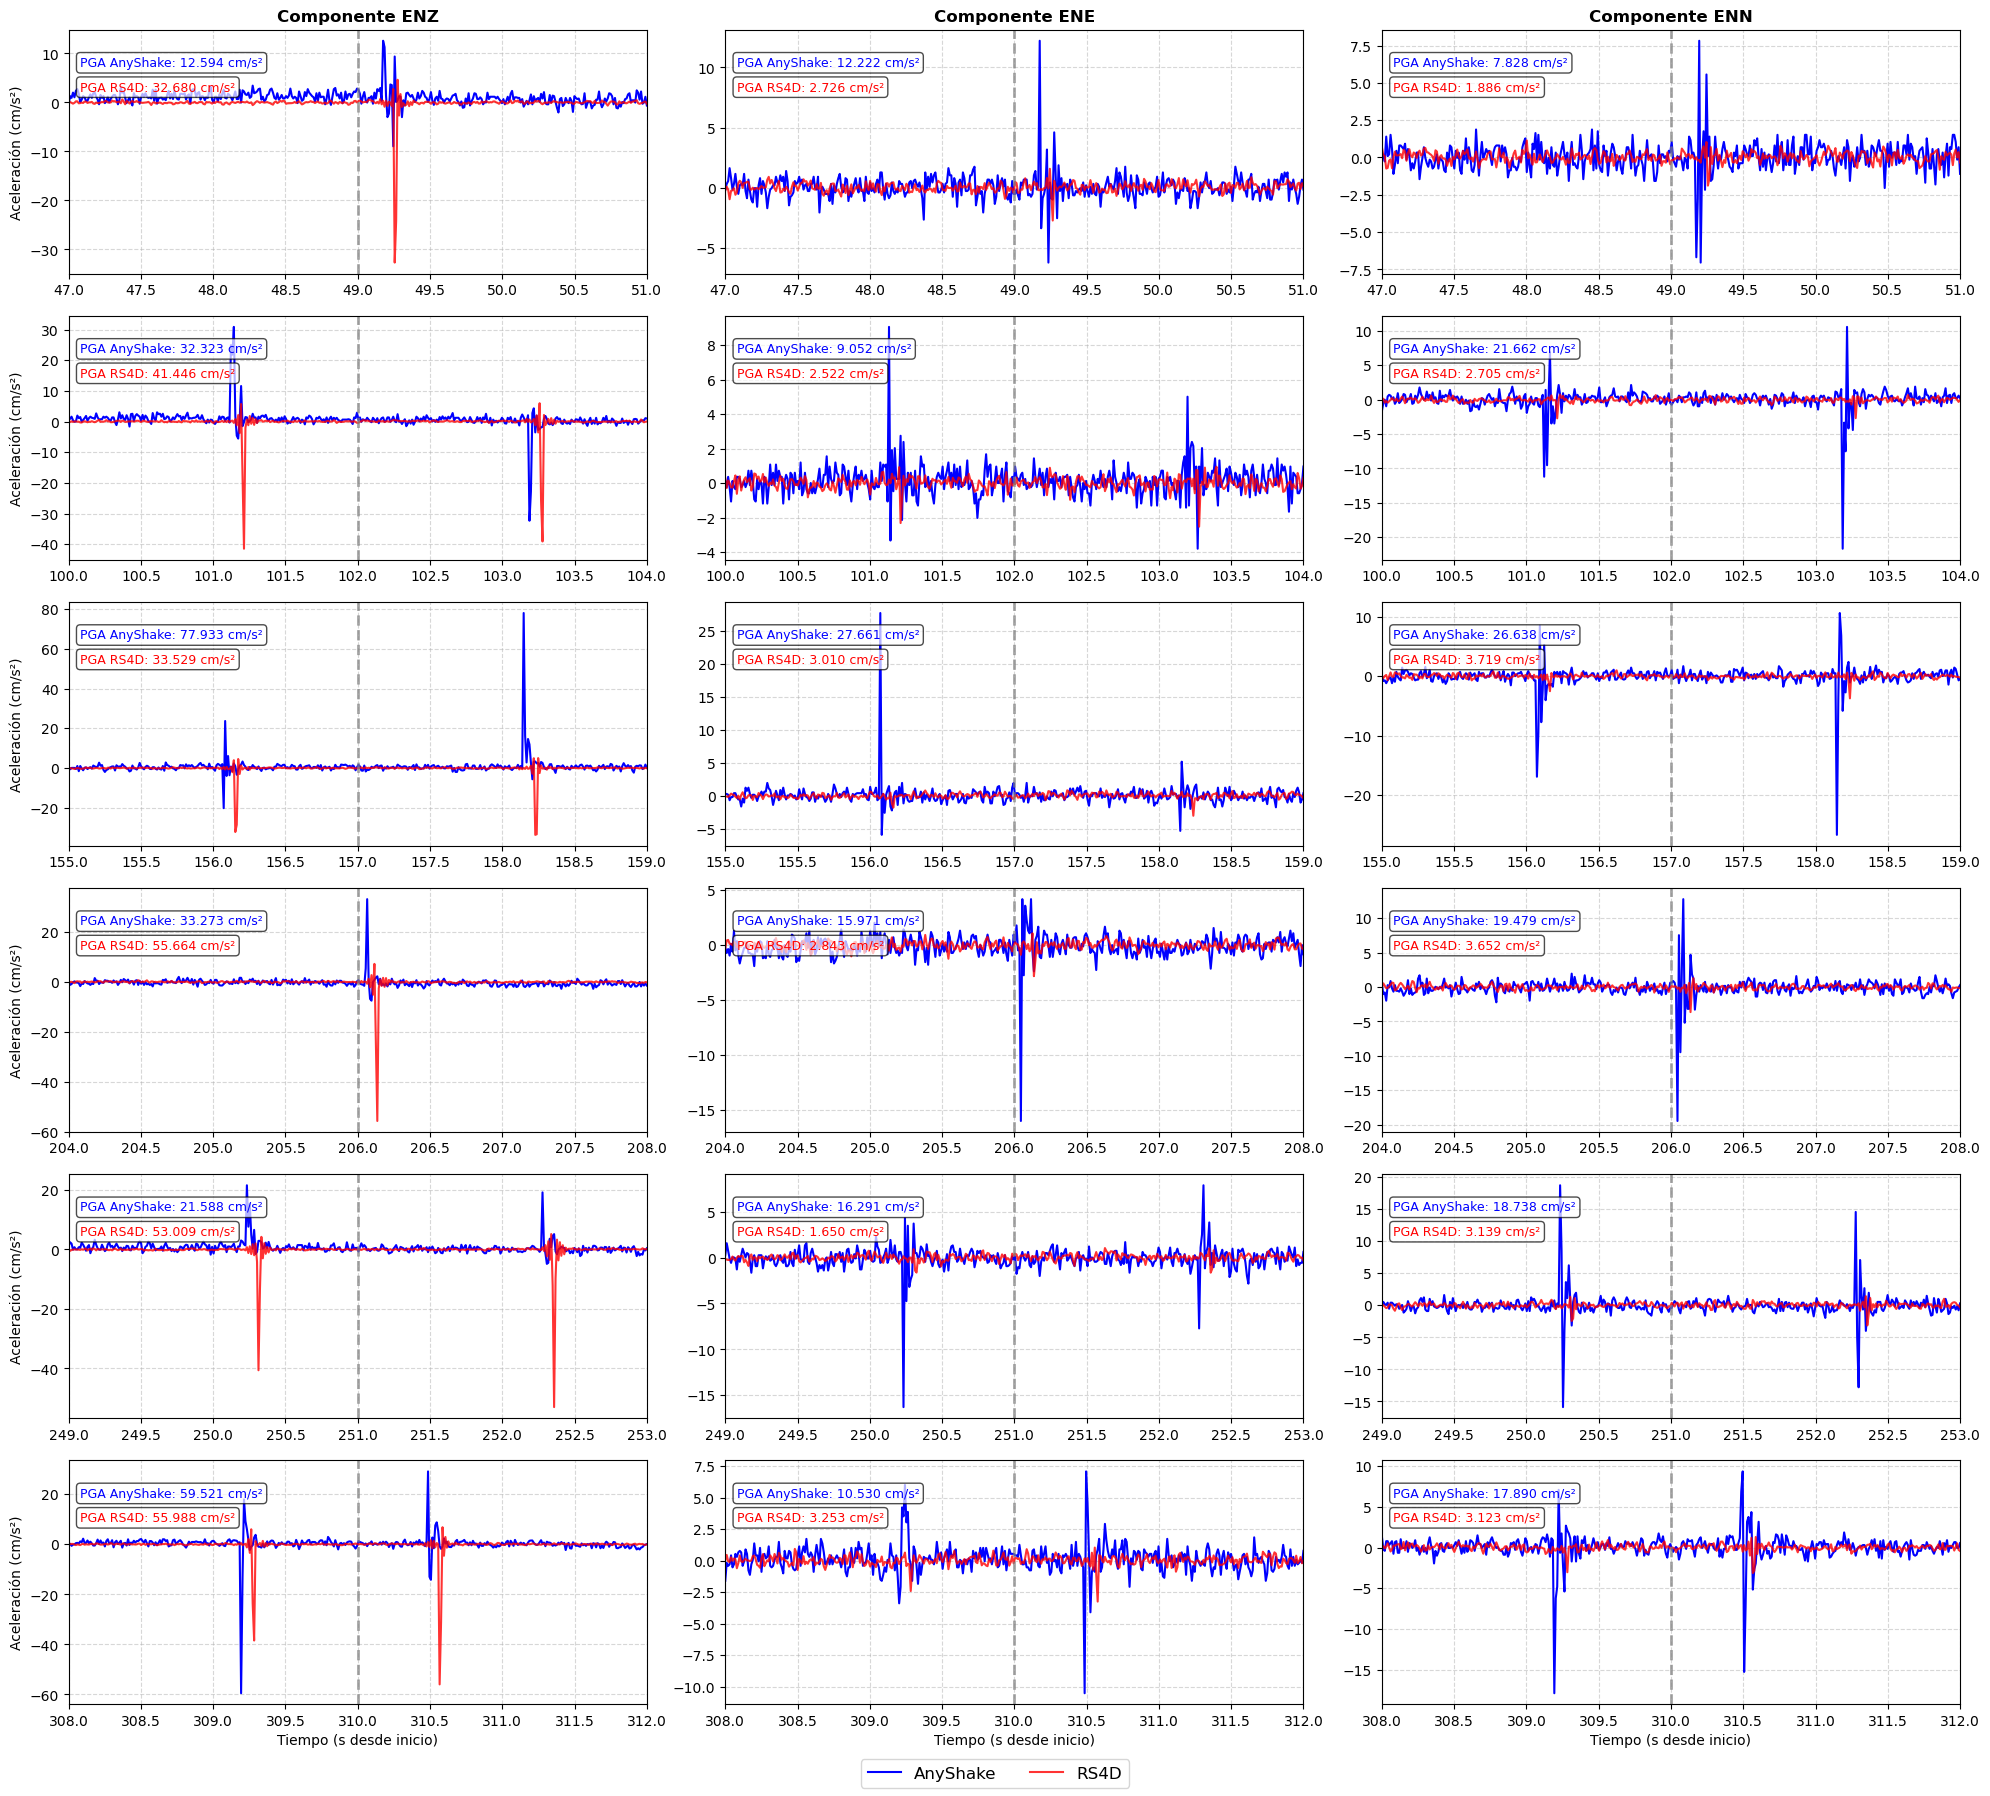

In [5]:
# Aplicar corrección de desfase temporal a RS4D (1 segundo de retraso)
desfase_segundos = 0.98  # RS4D está adelantada por 1 segundo

# Para cada componente de RS4D, aplicamos el desplazamiento
for tr in st_rs4d_gal:
    fs = tr.stats.sampling_rate
    muestras_desfase = int(desfase_segundos * fs)
    
    # Aplicar desplazamiento usando correlación cruzada para mayor precisión
    # Pero primero, un enfoque simple de desplazamiento de datos
    if muestras_desfase > 0:
        # Desplazar los datos (rellenar con ceros al principio)
        tr.data = np.roll(tr.data, muestras_desfase)
        tr.data[:muestras_desfase] = 0

# Tiempos de inicio de los impulsos (en segundos desde el inicio de los datos)
inicio_impulsos = [49, 102, 157, 206, 251, 310]
ventana_duracion = 10  # 10 segundos de duración total
n_impulsos = len(inicio_impulsos)
componentes = ['ENZ', 'ENE', 'ENN']
n_componentes = len(componentes)

# Listas para almacenar todos los valores de PGA
pga_anyshake_todos = []
pga_rs4d_todos = []

# Crear figura con subgráficos de 6x3
fig, axes = plt.subplots(n_impulsos, n_componentes, figsize=(20, 18))

# Definir colores para cada instrumento
colors = {'AnyShake': 'blue', 'RS4D': 'red'}

# Primero, verifiquemos la duración total de los datos
print("Duración de los datos:")
duracion_anyshake = st_anyshake_gal[0].stats.endtime - st_anyshake_gal[0].stats.starttime
duracion_rs4d = st_rs4d_gal[0].stats.endtime - st_rs4d_gal[0].stats.starttime
print(f"AnyShake: {duracion_anyshake} segundos")
print(f"RS4D: {duracion_rs4d} segundos")

# Para cada impulso y cada componente
for i, centro_impulso in enumerate(inicio_impulsos):
    # Calcular inicio y fin de la ventana centrada (5 segundos antes y después)
    ventana_inicio = centro_impulso - 2
    ventana_fin = centro_impulso + 2
    
    # Verificar si la ventana está dentro de los límites de los datos para ambos instrumentos
    if ventana_inicio < 0:
        print(f"Advertencia: La ventana del impulso {i+1} ({ventana_inicio}-{ventana_fin}s) está antes del inicio de los datos")
        ventana_inicio = 0  # Ajustar al inicio de los datos
        ventana_fin = 10    # Mantener 10 segundos de duración
    
    if ventana_fin > duracion_anyshake:
        print(f"Advertencia: La ventana del impulso {i+1} ({ventana_inicio}-{ventana_fin}s) está fuera de los límites de AnyShake")
        ventana_fin = duracion_anyshake  # Ajustar al final de los datos
        ventana_inicio = max(0, ventana_fin - 10)  # Mantener 10 segundos de duración
        
    if ventana_fin > duracion_rs4d:
        print(f"Advertencia: La ventana del impulso {i+1} ({ventana_inicio}-{ventana_fin}s) está fuera de los límites de RS4D")
        # No ajustamos aquí para no afectar a AnyShake, pero manejaremos RS4D por separado
    
    for j, comp in enumerate(componentes):
        ax = axes[i, j]
        
        # Reiniciar variables para este componente
        datos_anyshake = None
        datos_rs4d = None
        time_anyshake = None
        time_rs4d = None
        pga_anyshake = None
        pga_rs4d = None
        
        try:
            # Obtener datos de AnyShake para el componente actual
            tr_anyshake = st_anyshake_gal.select(channel=f"*{comp}")[0]
            
            # Calcular índices para la ventana
            fs = tr_anyshake.stats.sampling_rate
            inicio_muestra = int(ventana_inicio * fs)
            fin_muestra = int(ventana_fin * fs)
            
            # Verificar que los índices estén dentro del rango
            if inicio_muestra < 0:
                inicio_muestra = 0
            if fin_muestra > len(tr_anyshake.data):
                fin_muestra = len(tr_anyshake.data)
            
            # Extraer datos de la ventana
            datos_anyshake = tr_anyshake.data[inicio_muestra:fin_muestra]
            time_anyshake = np.linspace(ventana_inicio, ventana_fin, len(datos_anyshake))
            
            # Calcular PGA para AnyShake (máximo del valor absoluto)
            if datos_anyshake is not None and len(datos_anyshake) > 0:
                pga_anyshake = np.max(np.abs(datos_anyshake))
                pga_anyshake_todos.append(pga_anyshake)  # Almacenar para el histograma
            
            # Obtener datos de RS4D para el componente actual
            tr_rs4d = st_rs4d_gal.select(channel=f"*{comp}")[0]
            
            # Calcular índices para la ventana (teniendo en cuenta el desfase aplicado)
            fs_rs4d = tr_rs4d.stats.sampling_rate
            inicio_muestra_rs4d = int(ventana_inicio * fs_rs4d)
            fin_muestra_rs4d = int(ventana_fin * fs_rs4d)
            
            # Verificar que los índices estén dentro del rango
            if inicio_muestra_rs4d < 0:
                inicio_muestra_rs4d = 0
            if fin_muestra_rs4d > len(tr_rs4d.data):
                fin_muestra_rs4d = len(tr_rs4d.data)
            
            # Extraer datos de la ventana
            datos_rs4d = tr_rs4d.data[inicio_muestra_rs4d:fin_muestra_rs4d]
            time_rs4d = np.linspace(ventana_inicio, ventana_fin, len(datos_rs4d))
            
            # Calcular PGA para RS4D (máximo del valor absoluto)
            if datos_rs4d is not None and len(datos_rs4d) > 0:
                pga_rs4d = np.max(np.abs(datos_rs4d))
                pga_rs4d_todos.append(pga_rs4d)  # Almacenar para el histograma
            
            # Graficar ambas señales
            if datos_anyshake is not None and len(datos_anyshake) > 0:
                ax.plot(time_anyshake, datos_anyshake, 
                        color=colors['AnyShake'], linewidth=1.5, label='AnyShake')
            
            if datos_rs4d is not None and len(datos_rs4d) > 0:
                ax.plot(time_rs4d, datos_rs4d, 
                        color=colors['RS4D'], linewidth=1.5, label='RS4D', alpha=0.8)
            
            # Añadir línea vertical en el centro del impulso
            ax.axvline(x=centro_impulso, color='gray', linestyle='--', alpha=0.7, linewidth=2)
            
            # Mostrar valores de PGA en el gráfico
            if pga_anyshake is not None:
                ax.text(0.02, 0.85, f'PGA AnyShake: {pga_anyshake:.3f} cm/s²', 
                        transform=ax.transAxes, fontsize=9, color=colors['AnyShake'],
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
            
            if pga_rs4d is not None:
                ax.text(0.02, 0.75, f'PGA RS4D: {pga_rs4d:.3f} cm/s²', 
                        transform=ax.transAxes, fontsize=9, color=colors['RS4D'],
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
            
        except IndexError:
            print(f"Error: No se pudo encontrar el canal {comp} para el impulso {i+1}")
            ax.text(0.5, 0.5, f'Sin datos\n{comp}', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=12)
        except Exception as e:
            print(f"Error procesando impulso {i+1}, componente {comp}: {e}")
            ax.text(0.5, 0.5, f'Error\n{comp}', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=12)
        
        # Configurar etiquetas y título
        if i == n_impulsos - 1:
            ax.set_xlabel('Tiempo (s desde inicio)', fontsize=10)
        if j == 0:
            ax.set_ylabel('Aceleración (cm/s²)', fontsize=10)
        if i == 0:
            ax.set_title(f'Componente {comp}', fontsize=12, fontweight='bold')
        
        # Cuadrícula y límites
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(ventana_inicio, ventana_fin)

# Ajustar espaciado
plt.tight_layout()

# Añadir leyenda general
fig.legend(['AnyShake', 'RS4D'], loc='lower center', ncol=2, fontsize=12)

# Ajustar espacio para la leyenda
plt.subplots_adjust(bottom=0.05)

plt.savefig('6x3_plot.png', dpi=300, bbox_inches='tight')
plt.show()

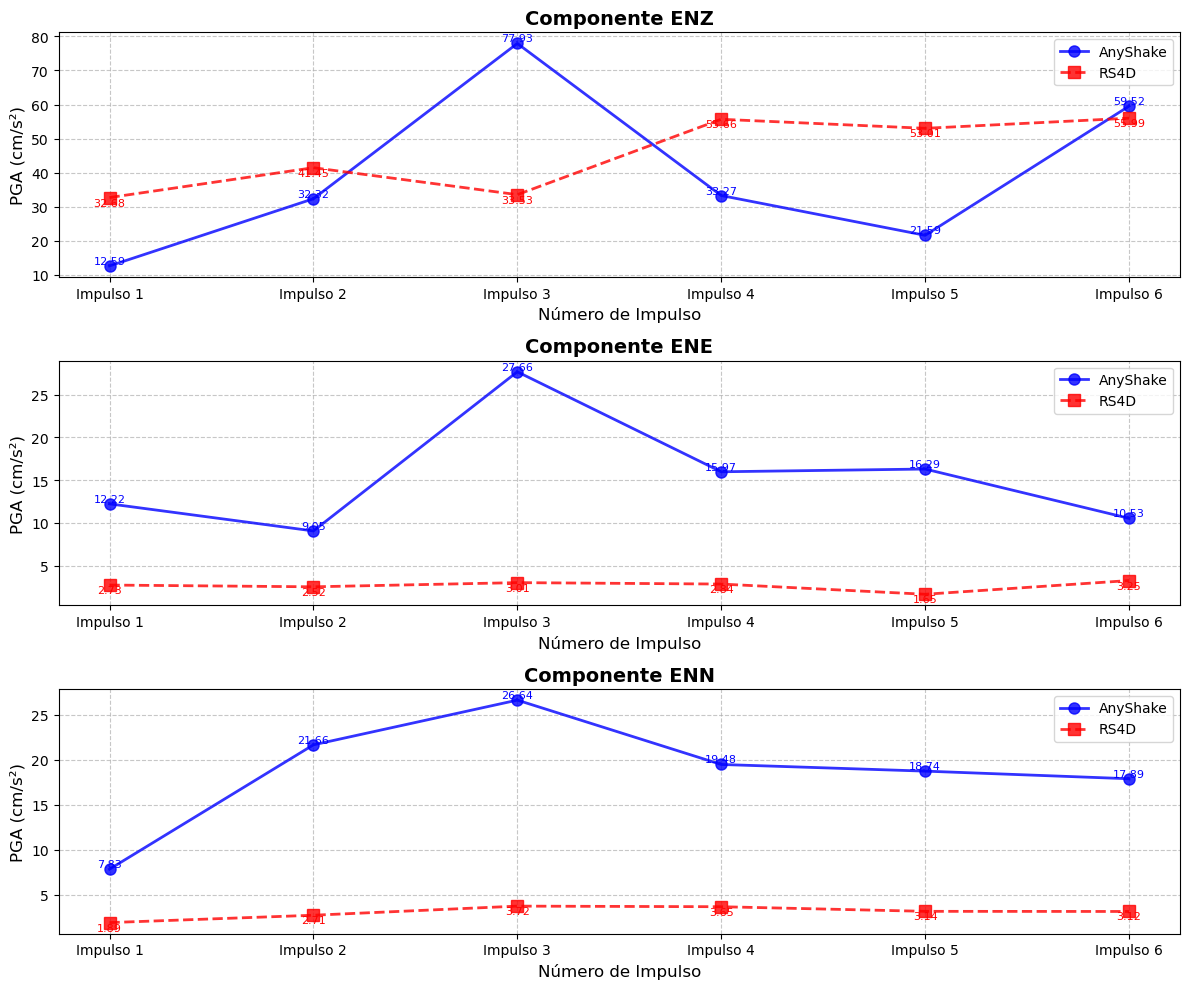

In [6]:
# Crear figura con 3 subgráficos (uno por componente)
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Colores para cada instrumento
colors = {'AnyShake': 'blue', 'RS4D': 'red'}

# Posiciones en el eje X para cada impulso
impulso_positions = np.arange(1, len(inicio_impulsos) + 1)

# Para cada componente
for j, comp in enumerate(componentes):
    ax = axes[j]
    
    # Listas para almacenar los PGA de esta componente
    pga_anyshake_comp = []
    pga_rs4d_comp = []
    
    # Para cada impulso, obtener los PGA de esta componente
    for i, centro_impulso in enumerate(inicio_impulsos):
        # Calcular inicio y fin de la ventana centrada
        ventana_inicio = centro_impulso - 2
        ventana_fin = centro_impulso + 2
        
        try:
            # Obtener datos de AnyShake para esta componente e impulso
            tr_anyshake = st_anyshake_gal.select(channel=f"*{comp}")[0]
            fs = tr_anyshake.stats.sampling_rate
            inicio_muestra = int(ventana_inicio * fs)
            fin_muestra = int(ventana_fin * fs)
            
            # Ajustar índices si es necesario
            inicio_muestra = max(0, inicio_muestra)
            fin_muestra = min(len(tr_anyshake.data), fin_muestra)
            
            # Extraer datos y calcular PGA
            datos_anyshake = tr_anyshake.data[inicio_muestra:fin_muestra]
            if len(datos_anyshake) > 0:
                pga_anyshake = np.max(np.abs(datos_anyshake))
                pga_anyshake_comp.append(pga_anyshake)
            else:
                pga_anyshake_comp.append(np.nan)
            
            # Obtener datos de RS4D para esta componente e impulso
            tr_rs4d = st_rs4d_gal.select(channel=f"*{comp}")[0]
            fs_rs4d = tr_rs4d.stats.sampling_rate
            inicio_muestra_rs4d = int(ventana_inicio * fs_rs4d)
            fin_muestra_rs4d = int(ventana_fin * fs_rs4d)
            
            # Ajustar índices si es necesario
            inicio_muestra_rs4d = max(0, inicio_muestra_rs4d)
            fin_muestra_rs4d = min(len(tr_rs4d.data), fin_muestra_rs4d)
            
            # Extraer datos y calcular PGA
            datos_rs4d = tr_rs4d.data[inicio_muestra_rs4d:fin_muestra_rs4d]
            if len(datos_rs4d) > 0:
                pga_rs4d = np.max(np.abs(datos_rs4d))
                pga_rs4d_comp.append(pga_rs4d)
            else:
                pga_rs4d_comp.append(np.nan)
                
        except Exception as e:
            print(f"Error procesando componente {comp}, impulso {i+1}: {e}")
            pga_anyshake_comp.append(np.nan)
            pga_rs4d_comp.append(np.nan)
    
    # Graficar los puntos y líneas para AnyShake
    ax.plot(impulso_positions, pga_anyshake_comp, 'o-', color=colors['AnyShake'], 
            linewidth=2, markersize=8, label='AnyShake', alpha=0.8)
    
    # Graficar los puntos y líneas para RS4D
    ax.plot(impulso_positions, pga_rs4d_comp, 's--', color=colors['RS4D'], 
            linewidth=2, markersize=8, label='RS4D', alpha=0.8)
    
    # Añadir etiquetas de valores
    for k, (pga_as, pga_rs4d) in enumerate(zip(pga_anyshake_comp, pga_rs4d_comp)):
        if not np.isnan(pga_as):
            ax.text(impulso_positions[k], pga_as, f'{pga_as:.2f}', 
                    fontsize=8, ha='center', va='bottom', color=colors['AnyShake'])
        if not np.isnan(pga_rs4d):
            ax.text(impulso_positions[k], pga_rs4d, f'{pga_rs4d:.2f}', 
                    fontsize=8, ha='center', va='top', color=colors['RS4D'])
    
    # Configurar el subgráfico
    ax.set_title(f'Componente {comp}', fontsize=14, fontweight='bold')
    ax.set_ylabel('PGA (cm/s²)', fontsize=12)
    ax.set_xlabel('Número de Impulso', fontsize=12)
    ax.set_xticks(impulso_positions)
    ax.set_xticklabels([f'Impulso {i+1}' for i in range(len(inicio_impulsos))])
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best')

# Ajustar espaciado
plt.tight_layout()

plt.savefig('Finall_results.png', dpi=300, bbox_inches='tight')
plt.show()